# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data
#### 6. TASK 6.6 

### 1. Importing your libraries and data

In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = 'cEeaybeDh3v72b12Dk3h'

In [5]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/NROU')

In [6]:
data.head(5)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [7]:
data.shape

(332, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

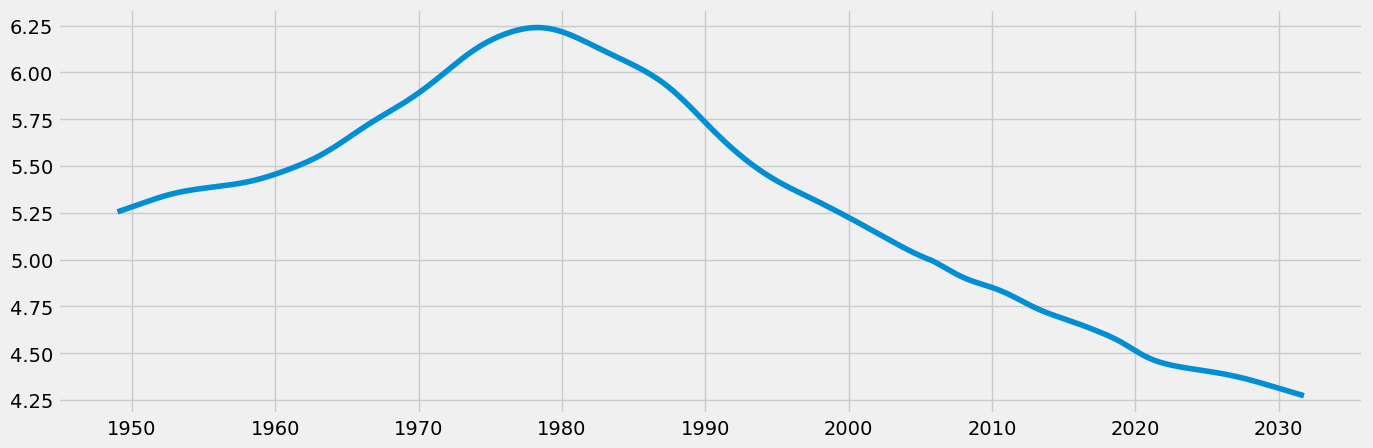

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [13]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [14]:
data_sub.shape

(162, 2)

In [15]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


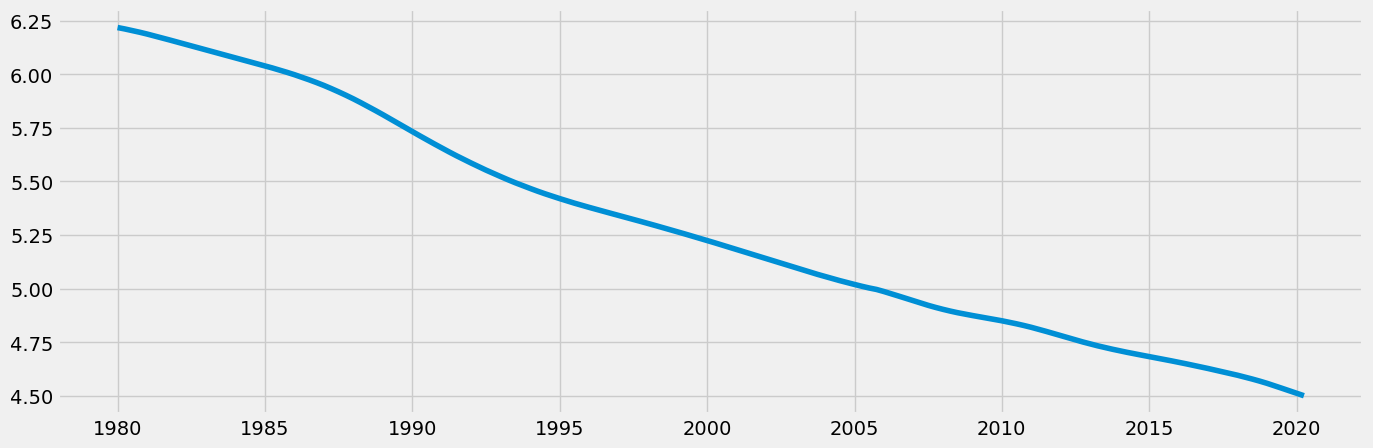

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

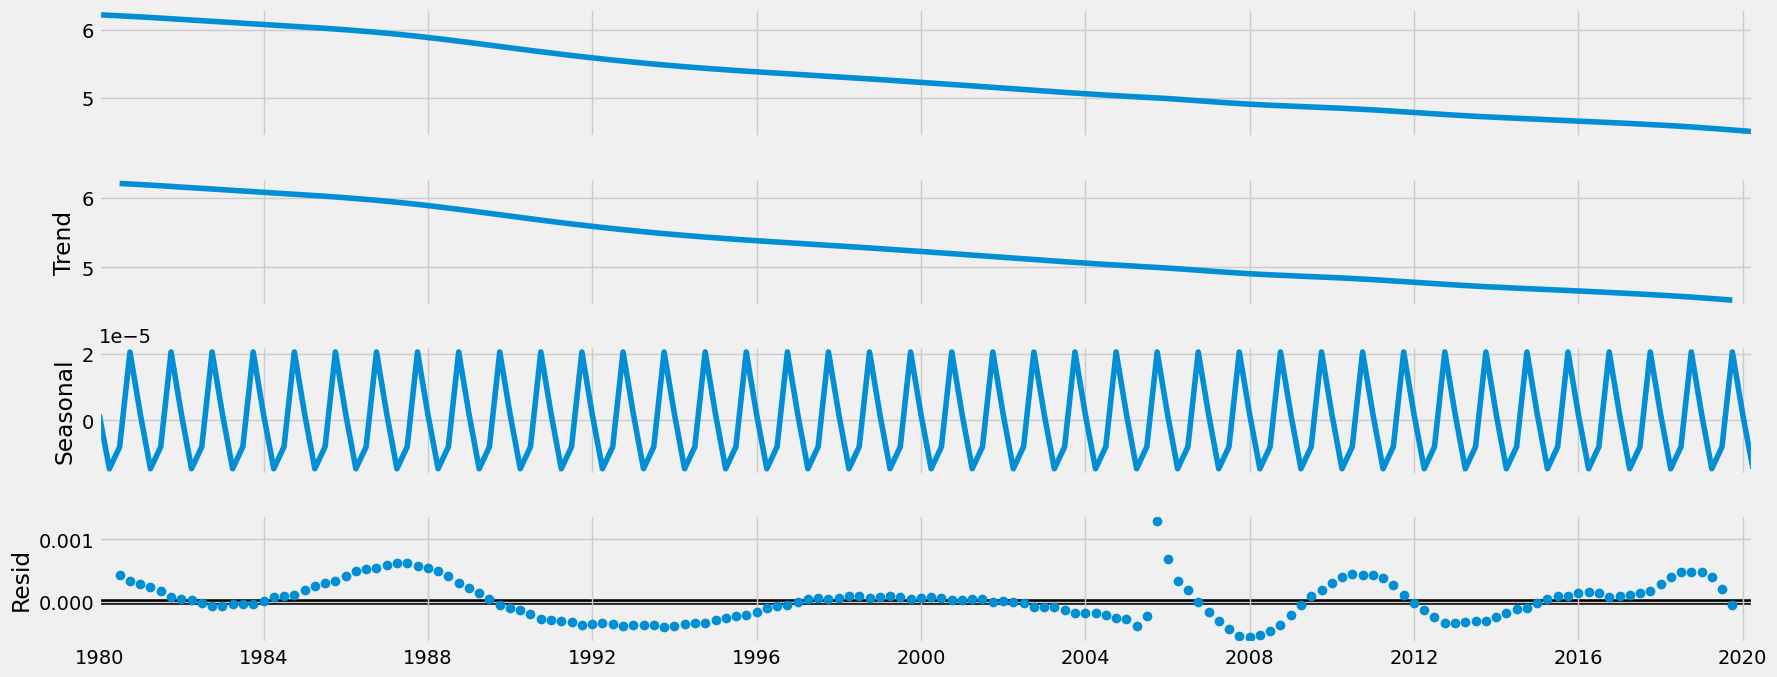

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


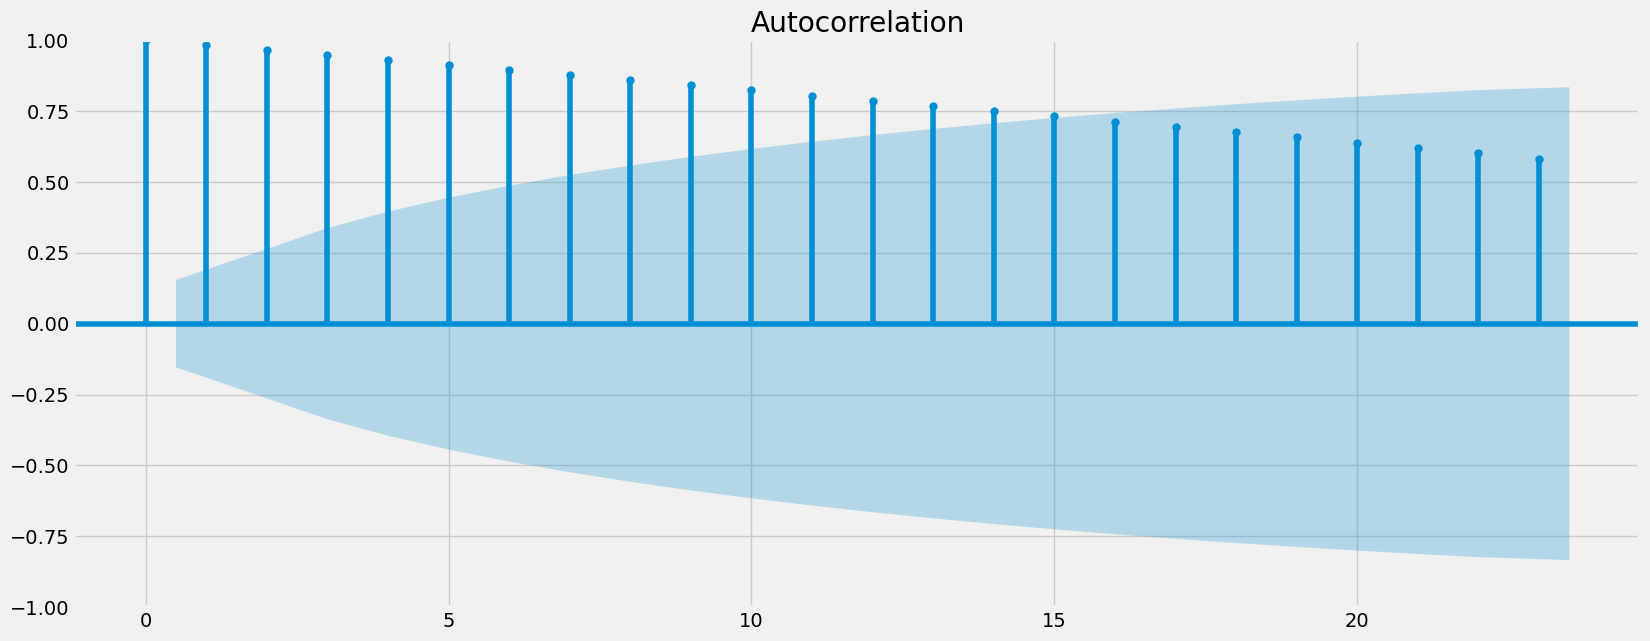

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [25]:
data_diff = data_sub - data_sub.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True) 
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

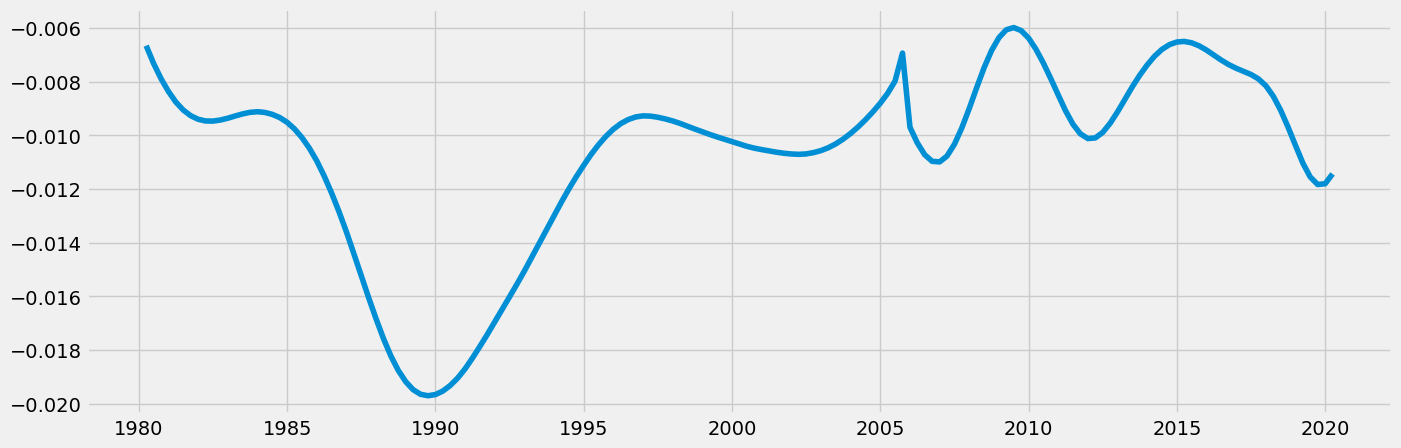

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


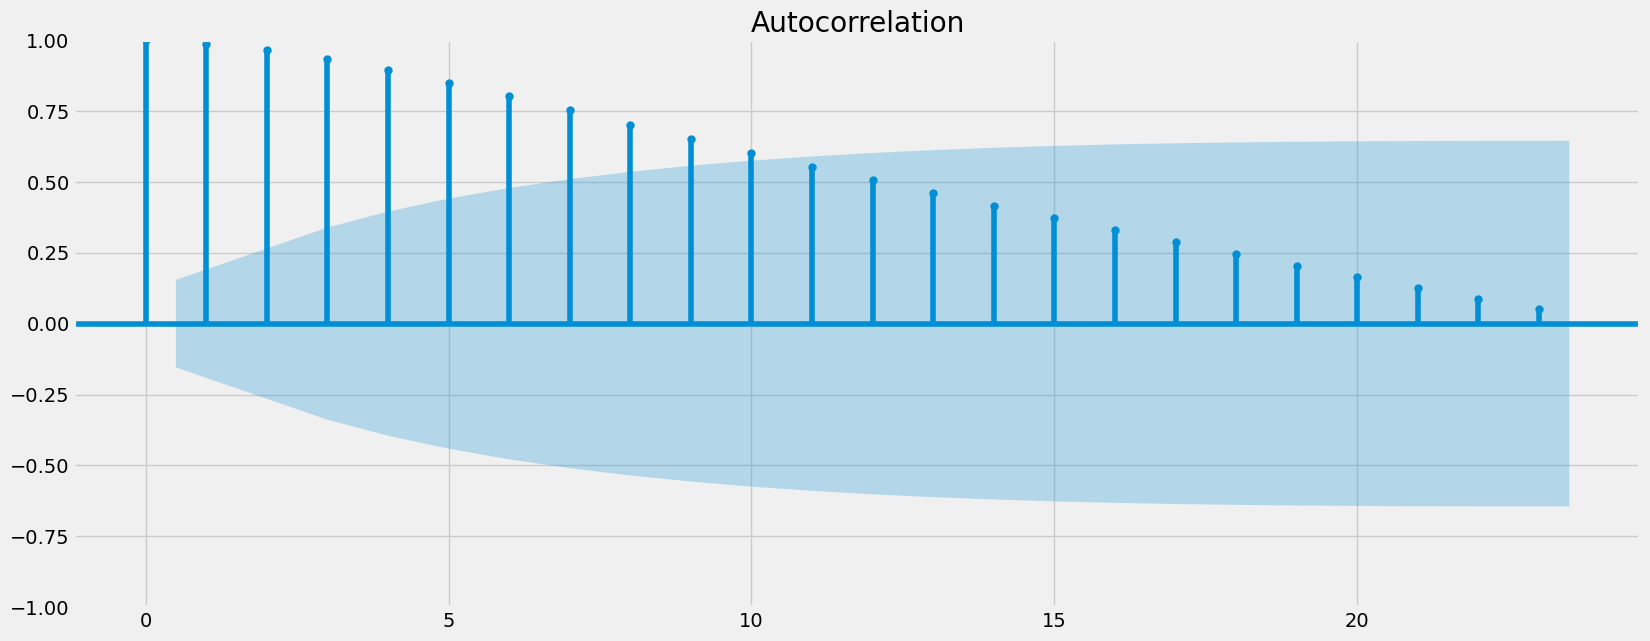

In [31]:
plot_acf(data_diff)
plt.show()

##### The unspoken rule of thumb is that you need at least 10 significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary.

### 6. TASK 6.6

#### 6.1 Importing data

#### For this task, I found population data available on the Institut national de la statistique et des études économiques website. The dataset contains yearly population counts in Paris from 1975-2023.
    https://www.insee.fr/en/statistiques/serie/001760155#Tableau
    

In [39]:
# Import data

path = r'/Users/kristincpeterson/Desktop/DataAnalytics/Achievement_6/Final Project - Espaces Verts'

In [40]:
df = pd.read_csv(os.path.join(path, '02 Data', 'Original_Data', 'Paris_population', 'annual_values.csv'))

In [41]:
df.head()

,"Label;""Population estimates - All - Ville de Paris"";""Codes"""
0,"idBank;""001760155"";"""""
1,"Last update;""15/02/2023 15:12"";"""""
2,"Period;"""";"""""
3,"2023;""2102650"";""P"""
4,"2022;""2117702"";""P"""


#### File uses semicolon (;) as field separators. Need to specify the delimiter using the 'sep' parameter, like pd.read_csv('file.csv', sep=';') for a semicolon-delimited file.

In [44]:
df = pd.read_csv(r'/Users/kristincpeterson/Desktop/DataAnalytics/Achievement_6/Final Project - Espaces Verts/02 Data/Original_Data/Paris_population/annual_values.csv', 
                 sep=';', 
                 index_col=None)

In [45]:
df.head()

,Label,Population estimates - All - Ville de Paris,Codes
0,idBank,001760155,NaN
1,Last update,15/02/2023 15:12,NaN
2,Period,NaN,NaN
3,2023,2102650,P
4,2022,2117702,P


In [46]:
df

,Label,Population estimates - All - Ville de Paris,Codes
0,idBank,001760155,NaN
1,Last update,15/02/2023 15:12,NaN
2,Period,NaN,NaN
3,2023,2102650,P
4,2022,2117702,P
5,2021,2131104,P
6,2020,2145906,A
7,2019,2165423,A
8,2018,2175601,A
9,2017,2187526,A


In [47]:
df.shape

(52, 3)

In [49]:
df.columns

Index(['Label', 'Population estimates - All - Ville de Paris', 'Codes'], dtype='object')

In [51]:
# Remove Codes columns

df.drop(columns=['Codes'], inplace=True)

In [52]:
# Rename columns

df.rename(columns = {'Label' : 'Year', 'Population estimates - All - Ville de Paris' : 'Population'},
                      inplace = True)

In [53]:
df.columns

Index(['Year', 'Population'], dtype='object')

In [57]:
df = df.dropna()

In [58]:
df.head()

,Year,Population
0,idBank,001760155
1,Last update,15/02/2023 15:12
3,2023,2102650
4,2022,2117702
5,2021,2131104


In [59]:
df = df.iloc[2:]

In [60]:
df.head()

,Year,Population
3,2023,2102650
4,2022,2117702
5,2021,2131104
6,2020,2145906
7,2019,2165423


In [67]:
df_sorted = df.sort_values(by='Year', ascending=True)

In [69]:
df_sorted.head()

,Year,Population
51,1975,2309074
50,1976,2286548
49,1977,2267113
48,1978,2249644
47,1979,2229529


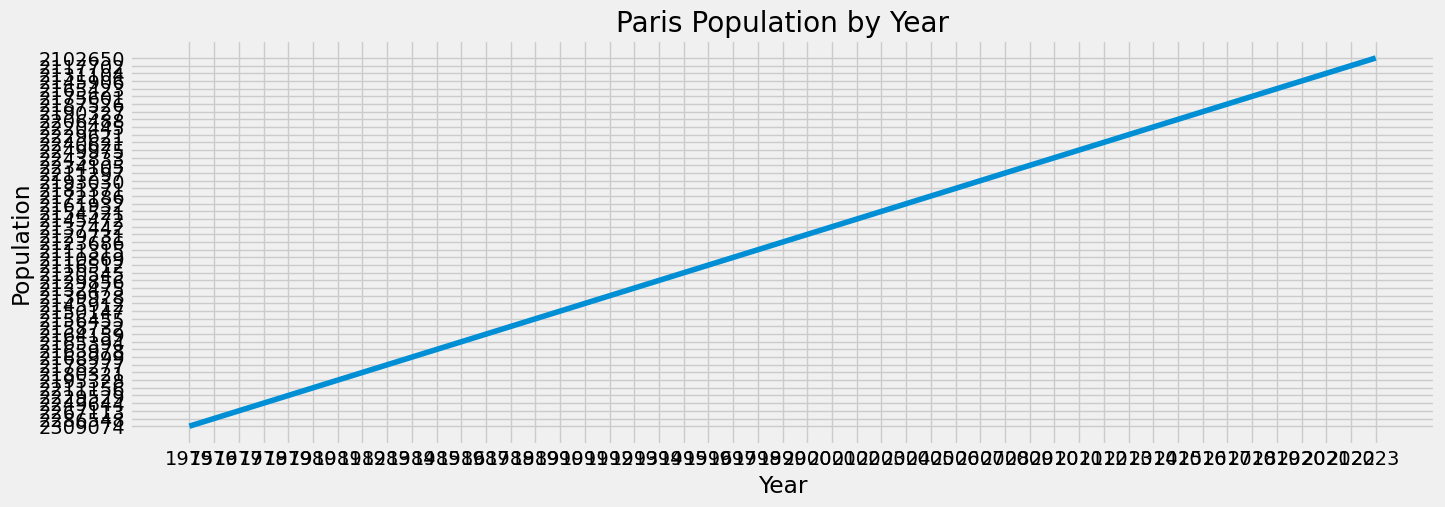

In [70]:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_sorted['Year'], df_sorted['Population'])

plt.xlabel('Year')  # Set the label for the x-axis
plt.ylabel('Population')  # Set the label for the y-axis
plt.title('Paris Population by Year')  # Set the title of the plot

plt.show()


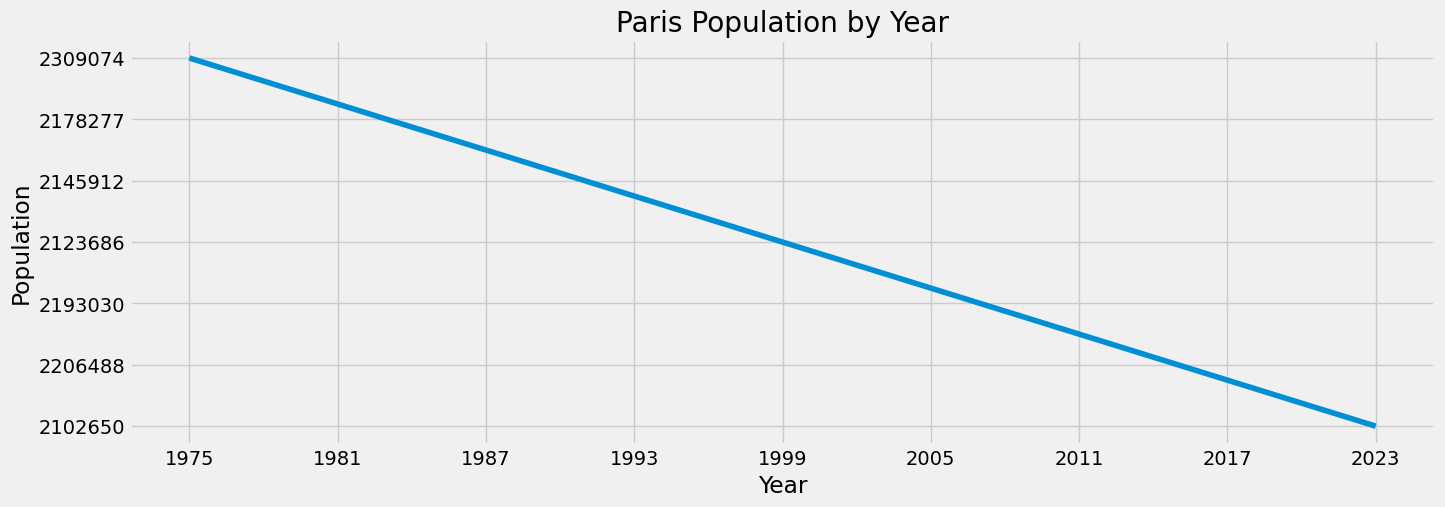

In [80]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_sorted['Year'], df_sorted['Population'])

plt.xlabel('Year')  # Set the label for the x-axis
plt.ylabel('Population')  # Set the label for the y-axis
plt.title('Paris Population by Year')  # Set the title of the plot

# Adjustments for x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))  # Adjust as needed

# Adjustments for y-axis
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(8))  # Reduce the number of y-axis ticks

# Invert y-axis to display population numbers in correct order
plt.gca().invert_yaxis()

plt.show()



#### 6.2. Subsetting, wrangling, and cleaning time-series data

In [81]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df_sorted.reset_index()

In [82]:
df_2.head()

,index,Year,Population
0,51,1975,2309074
1,50,1976,2286548
2,49,1977,2267113
3,48,1978,2249644
4,47,1979,2229529


In [85]:
# Set the "Year" column as the index

from datetime import datetime

df_2['datetime'] = pd.to_datetime(df_2['Year']) # Create a datetime column from "Year.""
df_2 = df_2.set_index('datetime') # Set the datetime as the index of the dataframe.
df_2.drop(['Year'], axis=1, inplace=True) # Drop the "Year" column.
df_2.head()

,index,Population
datetime,,
1975-01-01,51,2309074
1976-01-01,50,2286548
1977-01-01,49,2267113
1978-01-01,48,2249644
1979-01-01,47,2229529


In [87]:
df_3 = df_sorted

In [88]:
df_3.head()

,Year,Population
51,1975,2309074
50,1976,2286548
49,1977,2267113
48,1978,2249644
47,1979,2229529


In [89]:
# Set the "Year" column as the index

from datetime import datetime

df_3['datetime'] = pd.to_datetime(df_3['Year']) # Create a datetime column from "Year.""
df_3 = df_3.set_index('datetime') # Set the datetime as the index of the dataframe.
df_3.drop(['Year'], axis=1, inplace=True) # Drop the "Year" column.
df_3.head()

,Population
datetime,
1975-01-01,2309074
1976-01-01,2286548
1977-01-01,2267113
1978-01-01,2249644
1979-01-01,2229529


In [94]:
# Check for missing values (you shouldn't have any)

df_3.isnull().sum() 

Population    0
dtype: int64

In [95]:
# Check for duplicates

dups = df_3.duplicated()
dups.sum()

# No dups!

0

#### 6.3 Time-series analysis: decomposition

In [96]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_3, model='additive')

In [97]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

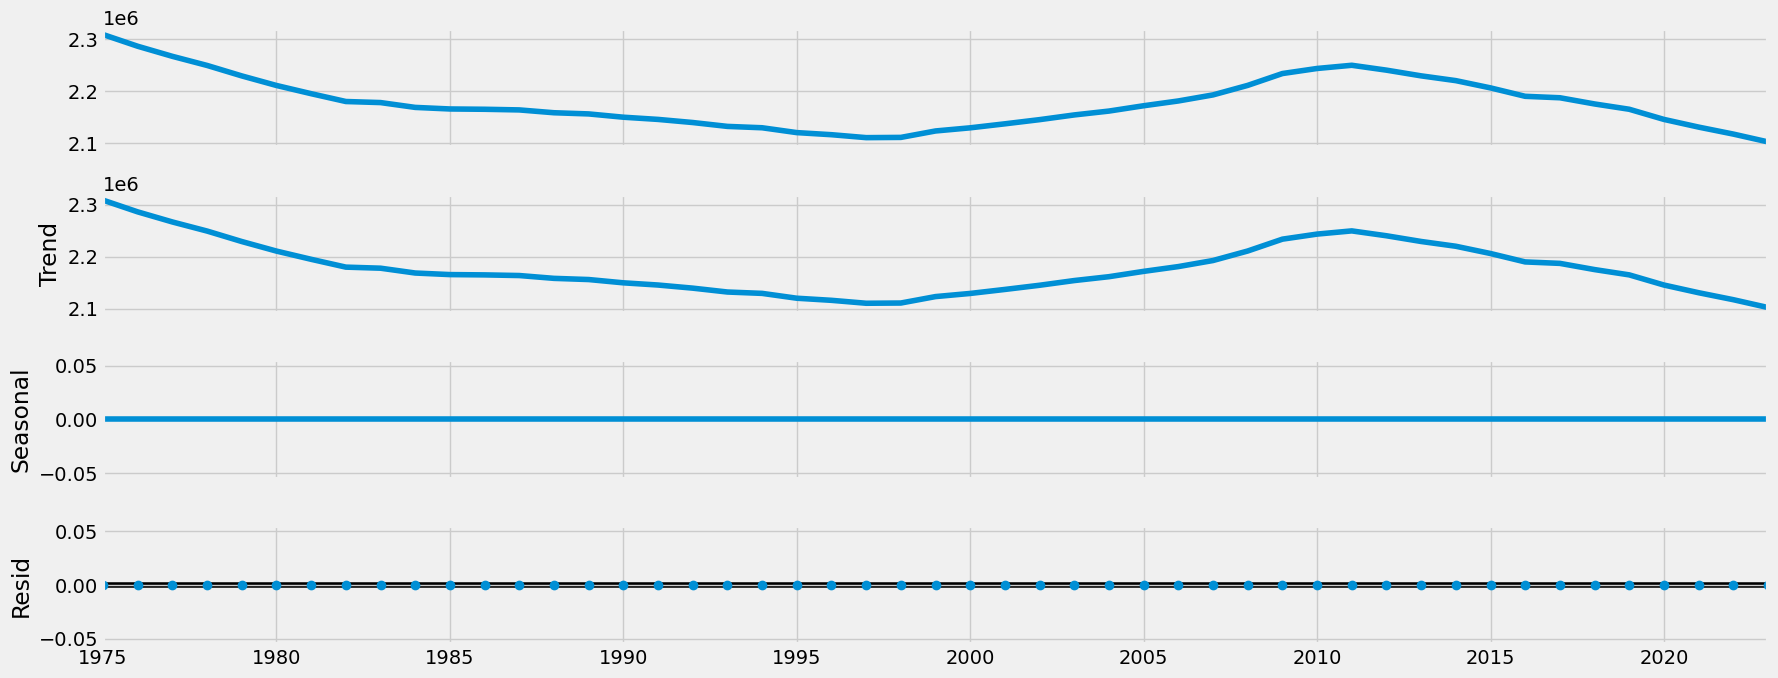

In [98]:
# Plot the separate components

decomposition.plot()
plt.show()

#### 6.4 Testing for stationarity

In [100]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_3['Population'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.257992
p-value                         0.185874
Number of Lags Used             2.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


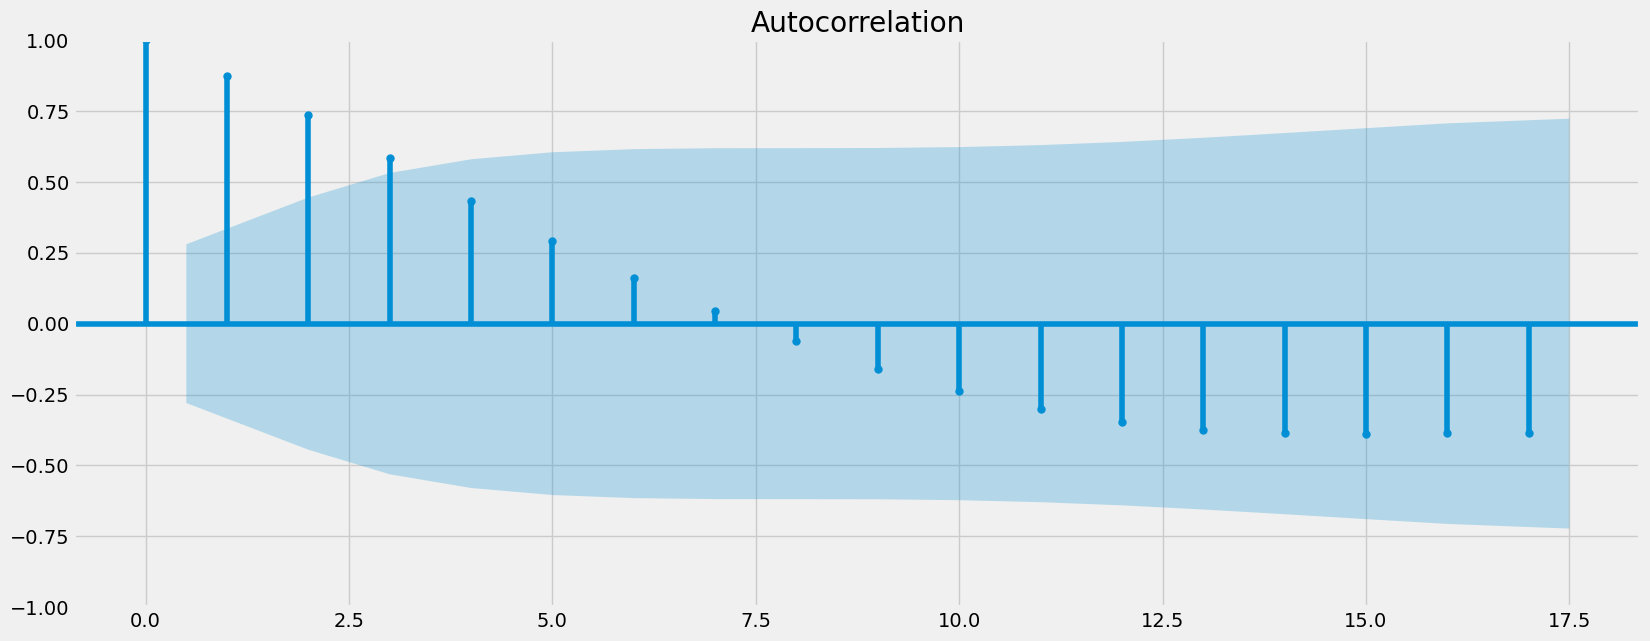

In [101]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_3)
plt.show()

### The test statistic (-2.257992) is smaller than the Critical Value at the 1% level (-3.581258) but larger than the 5% and 10% levels.
### The data is non-stationary (has a trend).

#### 6.5 Stationarizing the Paris Population Data

In [103]:
df_diff = df_3 - df_3.shift(1)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [105]:
# Check the data type of columns involved in the operation
(df_3['Population'].dtype)

dtype('O')

In [106]:
# Convert 'Population' to numeric, coercing errors to NaN
df_3['Population'] = pd.to_numeric(df_3['Population'], errors='coerce')

print(df)


    Year Population
3   2023    2102650
4   2022    2117702
5   2021    2131104
6   2020    2145906
7   2019    2165423
8   2018    2175601
9   2017    2187526
10  2016    2190327
11  2015    2206488
12  2014    2220445
13  2013    2229621
14  2012    2240621
15  2011    2249975
16  2010    2243833
17  2009    2234105
18  2008    2211297
19  2007    2193030
20  2006    2181371
21  2005    2172186
22  2004    2161932
23  2003    2154521
24  2002    2145472
25  2001    2137442
26  2000    2129731
27  1999    2123686
28  1998    2111315
29  1997    2110869
30  1996    2116512
31  1995    2120545
32  1994    2129856
33  1993    2132475
34  1992    2139928
35  1991    2145912
36  1990    2150147
37  1989    2156455
38  1988    2158732
39  1987    2164159
40  1986    2165394
41  1985    2165978
42  1984    2168999
43  1983    2178277
44  1982    2180321
45  1981    2195328
46  1980    2211156
47  1979    2229529
48  1978    2249644
49  1977    2267113
50  1976    2286548
51  1975    2309074


In [107]:
df_diff = df_3 - df_3.shift(1)

In [109]:
df_diff.dropna(inplace = True)

In [110]:
df_diff.head()

,Population
datetime,
1976-01-01,-22526.0
1977-01-01,-19435.0
1978-01-01,-17469.0
1979-01-01,-20115.0
1980-01-01,-18373.0


In [111]:
df_diff.columns

Index(['Population'], dtype='object')

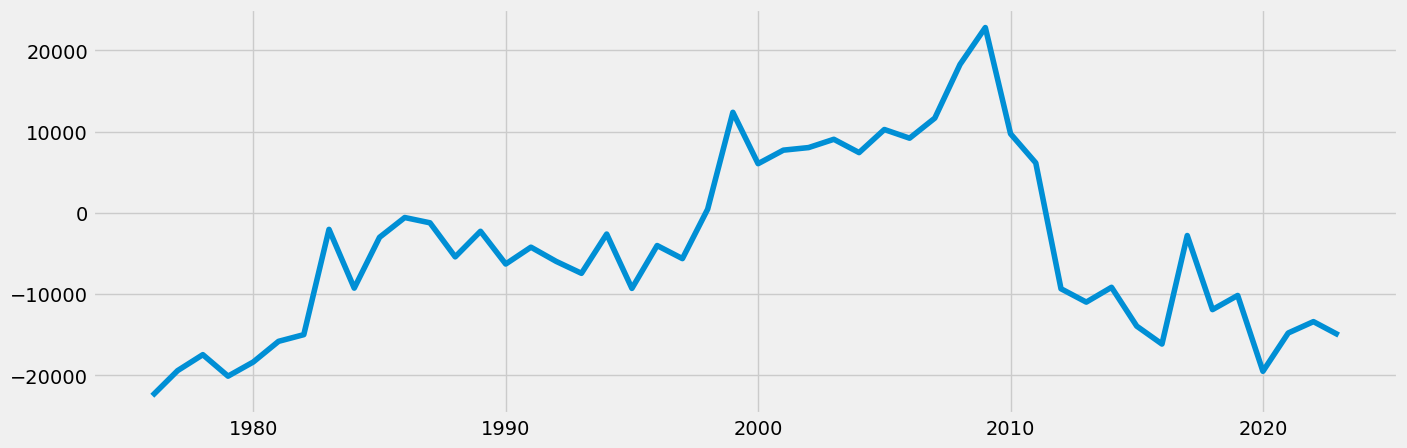

In [112]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [113]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.136348
p-value                         0.230152
Number of Lags Used             0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


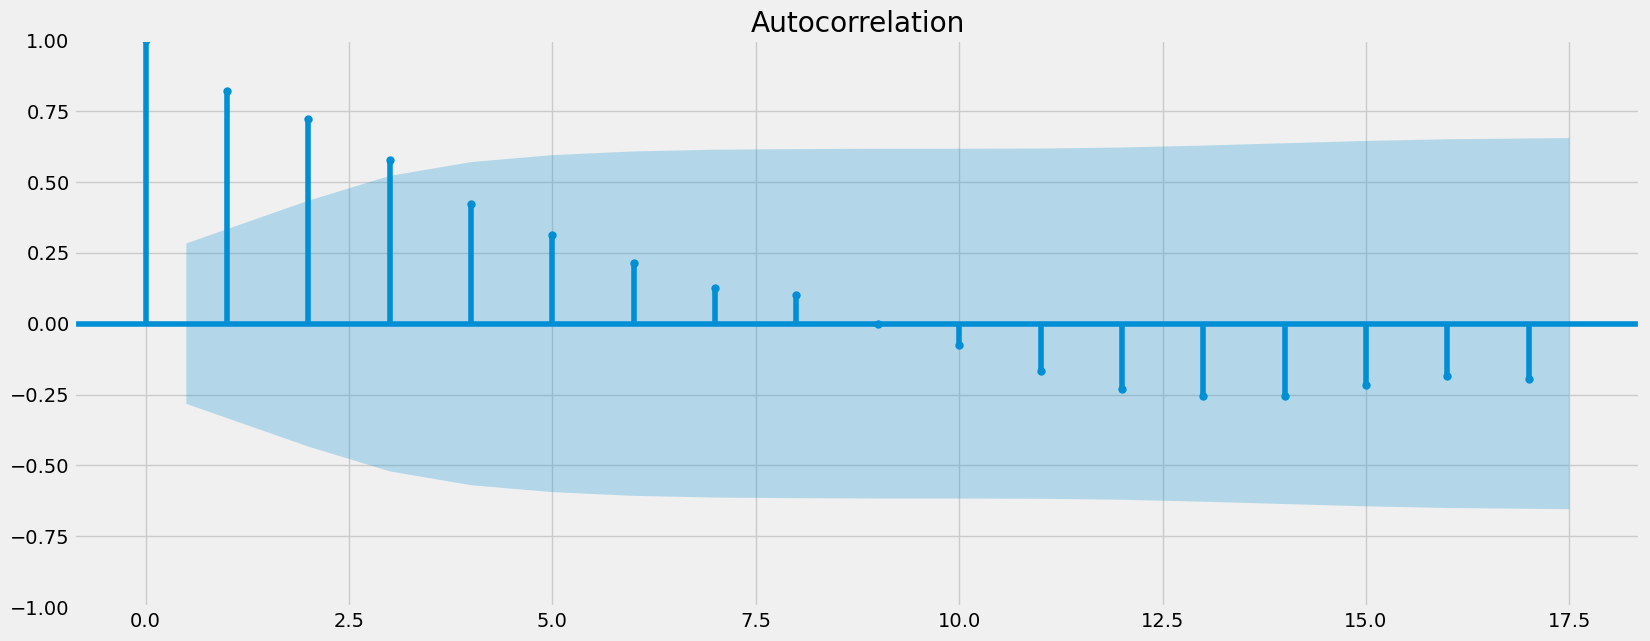

In [114]:
plot_acf(df_diff)
plt.show()

### The test statistic (-2.136348) is now smaller than the Critical Value at the 1%, 5% and 10% levels.
### The data is now stationary (no trend).